In [16]:
import numpy as np
import matplotlib.pylab as plt
from streaming_gmm import lightcurve, streaming_aov
import logging
import time as tm


%matplotlib inline
%load_ext autoreload
%autoreload 2

LC_PATH = 'data/lc_1.3444.614.B.mjd'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
def plot_periodogram(periods, s_aov, ax, title=''):
    p = periods[np.argmax(s_aov)]
    ax.plot(periods, s_aov)
    ax.set_title(title)
    ax.set_xlabel('Period')
    ax.set_ylabel('AOV Periodogram')
    ylims = ax.get_ylim()
    ax.plot([p, p], ylims, linewidth=10, alpha=.25)

## Synthetic light curve

In the cell below, we create a synthetic lightcurve with a known period.

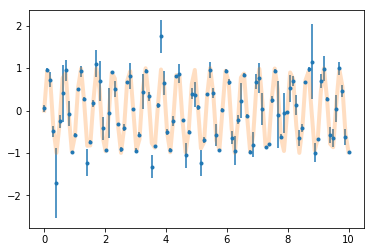

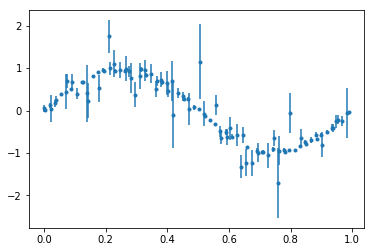

In [3]:
t = np.linspace(0.0, 10.0, num=100)
Pt = 0.532421
x = np.sin(2.0*np.pi*t/Pt)
e = np.random.gamma(1, scale=0.2, size=len(x))
y = x + np.random.randn(len(x))*e
plt.figure()
plt.errorbar(t, y, e, fmt='.')
plt.plot(t, x, linewidth=4, alpha=0.25)
plt.figure()
plt.errorbar(np.mod(t, Pt)/Pt, y, e, fmt='.')
N = len(t)

### Calculating period using P4J

First, as a sanity check, we use [P4J](https://github.com/phuijse/P4J) library to calculated the true period of our synthetic lightcurve.

Period:  0.532481357203


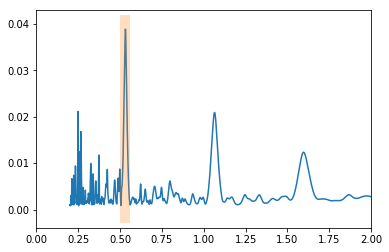

In [4]:
import P4J

p4j_model = P4J.periodogram(method='QMIEU')
p4j_model.set_data(t, y, e)

p4j_model.frequency_grid_evaluation(fmin=0.01, fmax=5.0, fresolution=1e-3)
p4j_model.finetune_best_frequencies(fresolution=0.01, n_local_optima=10)
freq, per = p4j_model.get_periodogram()

p4j_period = 1. / p4j_model.get_best_frequency()
print('Period: ', p4j_period)

plt.plot(1. / freq, per)
plt.xlim([0, 2.0])
ylims = plt.ylim()
plt.plot([p4j_period, p4j_period], ylims, linewidth=10, alpha=.25)

### Calculating the period using own implementation of AOV

We try to retrieve the correct period using our implementation of AOV period. **This period calculation is not in a streaming setting**.

Periodogram calculated in: 0.05466151237487793 secs
Period:  0.5329999999999996


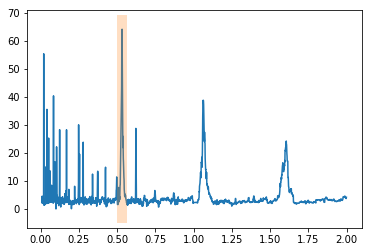

In [5]:
model = streaming_aov.StreamingAOV(plow=0.01, phigh=2.0, step=1e-3)

start_calculating_period_secs = tm.time()
model.update(t, y, e)
elapsed_time = tm.time() - start_calculating_period_secs

print('Periodogram calculated in: {} secs'.format(elapsed_time))

periods, aov = model.get_periodogram()
max_aov = model.get_period()
print('Period: ', model.get_period())
plt.plot(periods, aov)
ylims = plt.ylim()
plt.plot([max_aov, max_aov], ylims, linewidth=10, alpha=.25)

## Real lightcurve

Now we load a lightcurve from the MACHO dataset, and try to get its period.

In [25]:
lightcurve_df = lightcurve.read_from_file(LC_PATH, skiprows=3)
lightcurve_df = lightcurve.remove_unreliable_observations(lightcurve_df)
time, mag, error = lightcurve.unpack_df_in_arrays(lightcurve_df)
real_period = 0.937
print('Real period:', real_period)

Real period: 0.937


In [23]:
def plot_folded_lightcurve(time, mag, period):
    color = [0.392157, 0.584314 ,0.929412]
    T = 2 * period
    new_b = np.mod(time, period) / period
    idx = np.argsort(2 * new_b)
    plt.plot(new_b, mag, '*', color=color)
    plt.xlabel("Phase")
    plt.ylabel("Magnitude")
    plt.gca().invert_yaxis()

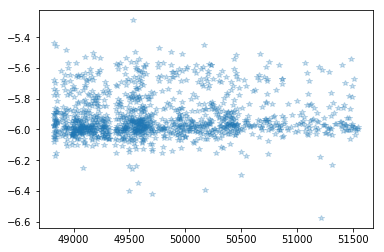

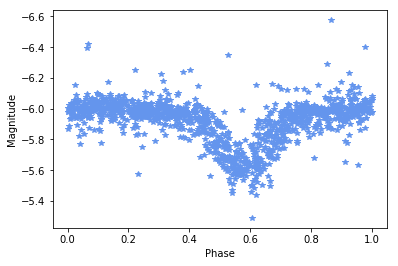

In [24]:
plt.figure()
plt.plot(time, mag, '*', alpha=0.25)

plt.figure()
plot_folded_lightcurve(time, mag, real_period)

### Calculating period using P4J

Period:  0.937207095131


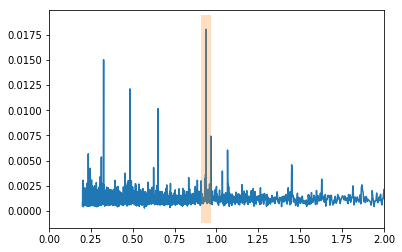

In [26]:
p4j_model = P4J.periodogram(method='QMIEU')
p4j_model.set_data(time, mag, error)

p4j_model.frequency_grid_evaluation(fmin=0.01, fmax=5.0, fresolution=1e-3)
p4j_model.finetune_best_frequencies(fresolution=0.01, n_local_optima=10)
freq, per = p4j_model.get_periodogram()

p4j_period = 1. / p4j_model.get_best_frequency()
print('Period: ', p4j_period)

plt.plot(1. / freq, per)
plt.xlim([0, 2.0])
ylims = plt.ylim()
plt.plot([p4j_period, p4j_period], ylims, linewidth=10, alpha=.25)

### Calculating the period using own AOV implementation

Periodogram calculated in: 0.45774269104003906 secs
Period:  0.9369999999999993


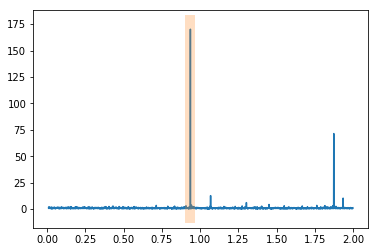

In [28]:
model = streaming_aov.StreamingAOV(plow=0.01, phigh=2.0, step=1e-3)

start_calculating_period_secs = tm.time()
model.update(time, mag, error)
elapsed_time = tm.time() - start_calculating_period_secs

print('Periodogram calculated in: {} secs'.format(elapsed_time))

periods, aov = model.get_periodogram()
max_aov = model.get_period()
print('Period: ', model.get_period())
plt.plot(periods, aov)
ylims = plt.ylim()
plt.plot([max_aov, max_aov], ylims, linewidth=10, alpha=.25)

### Calculating the period in a streaming way using AOV

Number of batches: 49
Observations per batch: 25
Streaming period  0.9369999999999993
Elapsed time for 49 batches: 1.020810842514038 secs


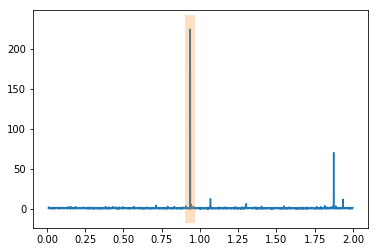

In [36]:
from streaming_gmm.streaming_lightcurve import to_chunks
from streaming_gmm.streaming_aov import StreamingAOV

real_period = 0.937
model = StreamingAOV()
periodograms = []

CHUNK_SIZE = 25

start_time = tm.time()
for time, mag, error in to_chunks(lightcurve_df, chunk_size=CHUNK_SIZE):
    batch_start_time = tm.time()
    model.update(time, mag, error)
    batch_elapsed_time = tm.time() - batch_start_time
    #print('Batch took {} secs'.format(batch_elapsed_time))
    periods, aov = model.get_periodogram()
    batch_size = time.shape[0]
    
    # We copy the aov array because if not it is updated with the last
    # model array.
    periodograms.append((periods, np.copy(aov), batch_size))
end_time = tm.time()
print('Number of batches:', len(periodograms))
print('Observations per batch:', CHUNK_SIZE)
print('Streaming period ', model.get_period())
print('Elapsed time for {} batches: {} secs'.format(len(periodograms),
                                                    end_time - start_time))

periods, aov = model.get_periodogram()
max_aov = model.get_period()
plt.plot(periods, aov)
ylims = plt.ylim()
plt.plot([max_aov, max_aov], ylims, linewidth=10, alpha=.25)

#### Plot of the evolution of the periodogram with the number of observations

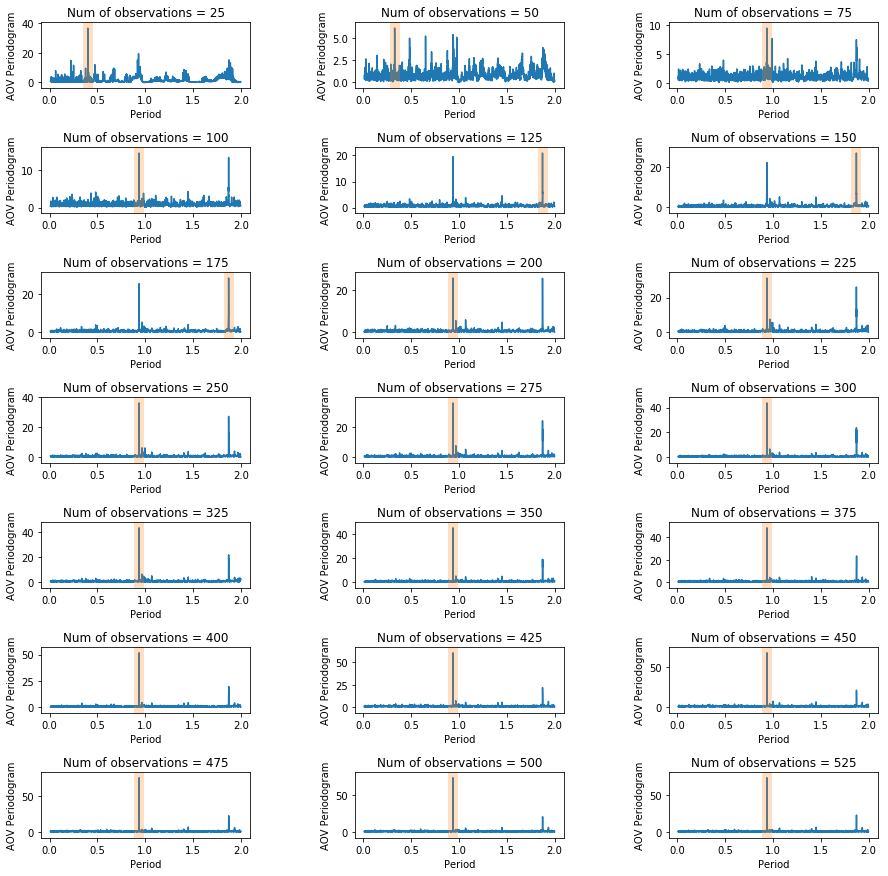

In [61]:
cols = 3
rows = len(periodograms[:21]) // cols
f, ax = plt.subplots(rows, cols, figsize=(15, 15))
points_seen = 0
for i in range(rows):
    for j in range(cols):
        index = i * cols + j
        if index < len(periodograms[:21]):
            periods, s_aov, batch_size = periodograms[index]
            points_seen += batch_size
            plot_periodogram(periods, s_aov, ax[i, j], 
                             title='Num of observations = {}'.format(
                                 points_seen))
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=.9)
plt.show()